### Bulding ML pIpelines useing sagemaker processing SDK
###  Orchestrating ML jobs from sagemaker
### .


In [22]:
# Coustomized docker container hosted in aws ecr 
openface_repository_uri = '166087373671.dkr.ecr.ap-south-1.amazonaws.com/vkonda/openface:latest'

In [3]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import datetime
#import ciso8601

Populating the interactive namespace from numpy and matplotlib


In [24]:
bucket = 'openface-preproces'
input_prefix = 'input_data'
preprocessed_prefix = 'processed_data'

In [25]:
import boto3
import sagemaker
from sagemaker import get_execution_role

from sagemaker.processing import ScriptProcessor, ProcessingInput

region  = boto3.session.Session().region_name

role = get_execution_role()

cmd = ["python3","-v"]

sklearn_processor = ScriptProcessor( base_job_name='openface-preprocessor',
                                     image_uri= openface_repository_uri,
                                     command=cmd,
                                     role=role,
                                     instance_type='ml.m5.large',
                                     max_runtime_in_seconds=600,
                                     instance_count=1,
                                     env={'mode': 'python'})

In [26]:
#input and output buckets

bucket = 'openface-preproces'
input_prefix = 'input_data'
preprocessed_prefix = 'processed_data'

In [27]:
!which python

/home/ec2-user/anaconda3/envs/python3/bin/python


In [28]:
sklearn_processor.run(code='preprocess.py',
                     arguments=['s3_input_bucket', bucket,
                               's3_input_key_prefix', input_prefix,
                               's3_output_bucket', bucket,
                               's3_output_key_prefix', preprocessed_prefix],
                    logs=False)


Job Name:  openface-preprocessor-2020-02-14-17-46-19-082
Inputs:  [{'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-ap-south-1-166087373671/openface-preprocessor-2020-02-14-17-46-19-082/input/code/preprocess.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  []
................................................................................!

In [30]:
client = boto3.client('sagemaker')
response = client.describe_processing_job(
    ProcessingJobName='openface-preprocessor-2020-02-14-17-46-19-082'
)
response

{'ProcessingInputs': [{'InputName': 'code',
   'S3Input': {'S3Uri': 's3://sagemaker-ap-south-1-166087373671/openface-preprocessor-2020-02-14-17-46-19-082/input/code/preprocess.py',
    'LocalPath': '/opt/ml/processing/input/code',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingJobName': 'openface-preprocessor-2020-02-14-17-46-19-082',
 'ProcessingResources': {'ClusterConfig': {'InstanceCount': 1,
   'InstanceType': 'ml.m5.large',
   'VolumeSizeInGB': 30}},
 'StoppingCondition': {'MaxRuntimeInSeconds': 600},
 'AppSpecification': {'ImageUri': '166087373671.dkr.ecr.ap-south-1.amazonaws.com/vkonda/openface:latest',
  'ContainerEntrypoint': ['python3',
   '-v',
   '/opt/ml/processing/input/code/preprocess.py'],
  'ContainerArguments': ['s3_input_bucket',
   'openface-preproces',
   's3_input_key_prefix',
   'input_data',
   's3_output_bucket',
   'openface-preproces',
   's3_output_key

In [37]:
response['ProcessingEndTime']

datetime.datetime(2020, 2, 14, 17, 52, 58, tzinfo=tzlocal())

In [36]:
response['ProcessingStartTime']

datetime.datetime(2020, 2, 14, 17, 47, 50, tzinfo=tzlocal())

In [ ]:
client = boto3.client('sagemaker')
response = client.stop_processing_job(
    ProcessingJobName='openface-preprocessor-2020-02-14-14-44-35-346')

response

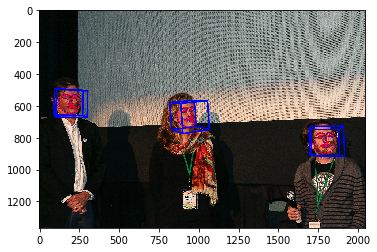

In [17]:
img=mpimg.imread('sample1.jpg')
imgplot = plt.imshow(img)
plt.show()

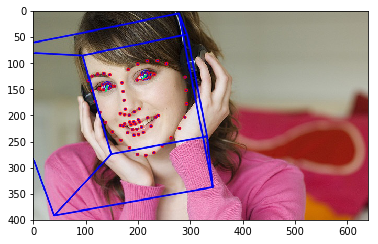

In [20]:
img=mpimg.imread('sample2.jpg')
imgplot = plt.imshow(img)
plt.show()

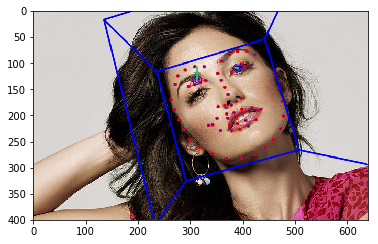

In [21]:
img=mpimg.imread('sample3.jpg')
imgplot = plt.imshow(img)
plt.show()

In [70]:
%%writefile preprocess.py
#!/usr/bin/env python3

print('Script started processing')
import boto3
import os
import sys
import subprocess

def main():
    print('Script started processing main')
    end_sync = 'aws s3 sync /tmp/processed_data s3://openface-preproces/processed_data' 

    start_sync = 'aws s3 sync s3://openface-preproces/inupt_data /tmp/input_data' 

    files = ['sample1.jpg','sample2.jpg','sample3.jpg','sample4.jpg','sample5.jpg','sample6.jpg']

    subprocess.check_call(start_sync,shell = True) 
    print('Script started processing main')
    for file in files:
        output_file_name = file.split(".")[0]
        input_file  = "/tmp/input_data/{}".format(file)
        output_file = "/tmp/processed_data/{}".format(output_file_name)
        cmd = "{} -f {} -out_dir {}".format('FaceLandmarkImg', input_file,output_file)
        subprocess.check_call(cmd,shell = True)

    cmd = "{} -f {} -out_dir {}".format('FeatureExtraction', '/tmp/input_data/2015-10-15-15-14.avi','/tmp/processed_data/2015-10-15-15-14')

    subprocess.check_call(cmd,shell = True)  

    cmd = "{} -f {} -out_dir {}".format('FaceLandmarkVidMulti', '/tmp/input_data/multi_face.avi','/tmp/processed_data/multi_face')

    subprocess.check_call(cmd, shell = True)

    subprocess.check_call(end_sync,shell = True) 
    print('Script processing done')
if __name__ == "__main__":
    
    main()

Overwriting preprocess.py


In [19]:
import boto3
import botocore

BUCKET_NAME = 'openface-preproces' # replace with your bucket name
KEY = 'processed_data/sample3/sample3.jpg' # replace with your object key

s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, '/home/ec2-user/SageMaker/sample3.jpg')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [ ]:
from PIL import Image  